In [1]:
import pandas as pd
import numpy as np

In [29]:
df=pd.read_csv("Train.csv")
df.drop(columns=["name","boat","body","cabin","embarked","ticket","home.dest"],inplace=True)
df = df.fillna(df["age"].mean())
df.head()

,pclass,survived,sex,age,sibsp,parch,fare
0,3.0,0.0,female,29.838978,0.0,0.0,7.750
1,2.0,0.0,male,39.000000,0.0,0.0,26.000
2,2.0,1.0,female,40.000000,0.0,0.0,13.000
3,3.0,1.0,female,31.000000,1.0,1.0,20.525
4,3.0,1.0,female,29.838978,2.0,0.0,23.250


In [30]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
df['sex']= label_encoder.fit_transform(df['sex']) 
df.head() 

,pclass,survived,sex,age,sibsp,parch,fare
0,3.0,0.0,0,29.838978,0.0,0.0,7.750
1,2.0,0.0,1,39.000000,0.0,0.0,26.000
2,2.0,1.0,0,40.000000,0.0,0.0,13.000
3,3.0,1.0,0,31.000000,1.0,1.0,20.525
4,3.0,1.0,0,29.838978,2.0,0.0,23.250


In [33]:
def entropy(col):
    
    counts = np.unique(col,return_counts=True)
    N = float(col.shape[0])
    
    ent = 0.0
    
    for ix in counts[1]:
        p  = ix/N
        ent += (-1.0*p*np.log2(p))
    
    return ent
    
    
def divide_data(x_data,fkey,fval):
    #Work with Pandas Data Frames
    x_right = pd.DataFrame([],columns=x_data.columns)
    x_left = pd.DataFrame([],columns=x_data.columns)
    
    for ix in range(x_data.shape[0]):
        val = x_data[fkey].loc[ix]
        
        if val > fval:
            x_right = x_right.append(x_data.loc[ix])
        else:
            x_left = x_left.append(x_data.loc[ix])
            
    return x_left,x_right

def info_gain(x_data,fkey,fval):
    left,right=divide_data(x_data,fkey,fval)
    l=float(left.shape[0])/x_data.shape[0]
    r=float(right.shape[0])/x_data.shape[0]
    if left.shape[0]==0 or right.shape[0]==0:
        return -10000000
    i_gain=entropy(x_data.survived)-(l*entropy(left.survived)+r*entropy(right.survived))
    return i_gain



In [34]:
for i in ["pclass","sex","age","sibsp","parch","fare"]:
    print(i)
    print(info_gain(df,i,df[i].mean()))

pclass
0.055456910002982474
sex
0.19274737190850932
age
0.001955929827451075
sibsp
0.006492394392888956
parch
0.01975608012294816
fare
0.04242793401428169


In [96]:
class DecisionTree:
    def __init__(self,depth=0,max_depth=5):
        self.left=None
        self.right=None
        self.fkey=None
        self.fval=None
        self.depth=depth
        self.max_depth=max_depth
        self.target=None
    def train(self,xtrain):
        features=["pclass","sex","age","sibsp","parch","fare"]
        gains_list=[]
        for i in features:
            ig=info_gain(xtrain,i,xtrain[i].mean())
            gains_list.append(ig)
        self.fkey=features[np.argmax(gains_list)]
        self.fval=xtrain[self.fkey].mean()

        data_left,data_right=divide_data(xtrain,self.fkey,self.fval)
        data_left=data_left.reset_index(drop=True)
        data_right=data_right.reset_index(drop=True)
        print("Making Tree Features is",self.fkey)
        #if the node is a leaf node
        if data_left.shape[0]==0 or data_right.shape[0]==0:
            if xtrain.survived.mean()>=0.5:
                self.target=1
            else:
                self.target=0
            return
        #if reached max depth before leaf node
        if self.depth>=self.max_depth:
            if xtrain.survived.mean()>=0.5:
                self.target=1
            else:
                self.target=0
            return
        self.left=DecisionTree(depth=self.depth+1,max_depth=self.max_depth)
        self.left.train(data_left)
        self.right=DecisionTree(depth=self.depth+1,max_depth=self.max_depth)
        self.right.train(data_right)

        if xtrain.survived.mean()>=0.5:
            self.target=1
        else:
            self.target=0
        return
    def predict(self,test):
        if test[self.fkey]>self.fval:
            if self.right is None:
                return self.target
            return self.right.predict(test)
        else:
            if self.left is None:
                return self.target
            return self.left.predict(test)


In [97]:
split = int(0.7*df.shape[0])
train_data = df[:split]
test_data = df[split:]
test_data = test_data.reset_index(drop=True)

In [98]:
dt=DecisionTree()
dt.train(train_data)

Making Tree Features is sex
Making Tree Features is pclass
Making Tree Features is parch
Making Tree Features is fare
Making Tree Features is fare
Making Tree Features is fare
Making Tree Features is fare
Making Tree Features is age
Making Tree Features is age
Making Tree Features is age
Making Tree Features is fare
Making Tree Features is pclass
Making Tree Features is age
Making Tree Features is age
Making Tree Features is age
Making Tree Features is age
Making Tree Features is age
Making Tree Features is sibsp
Making Tree Features is fare
Making Tree Features is fare
Making Tree Features is parch
Making Tree Features is age
Making Tree Features is age
Making Tree Features is age
Making Tree Features is parch
Making Tree Features is fare
Making Tree Features is parch
Making Tree Features is age
Making Tree Features is fare
Making Tree Features is fare
Making Tree Features is age
Making Tree Features is age
Making Tree Features is fare
Making Tree Features is parch
Making Tree Feature

In [99]:
print(dt.fkey)
print(dt.fval)
print(dt.left.fkey)
print(dt.right.fkey)

sex
0.6543909348441926
pclass
fare


In [42]:
y_actual = test_data["survived"]
y_pred = []
c=0
for ix in range(test_data.shape[0]):
    y_pred.append(dt.predict(test_data.loc[ix]))
y_pred = label_encoder.fit_transform(y_pred)
#y_pred = np.array(y_pred).reshape((-1,1))
acc = np.sum(np.array(y_pred)==np.array(y_actual))/len(y_pred)
print(acc)

0.7557755775577558


In [43]:
np.array(y_pred)==np.array(y_actual)

array([ True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
        True, False,  True, False,  True,  True, False,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False, False,  True,
        True,  True,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,

In [45]:
from sklearn.tree import DecisionTreeClassifier
sk_tree = DecisionTreeClassifier(criterion='gini',max_depth=5)
input_cols=["pclass","sex","age","sibsp","parch","fare"]
sk_tree.fit(train_data[input_cols],train_data["survived"])
sk_tree.predict(test_data[input_cols])
sk_tree.score(test_data[input_cols],test_data["survived"])

0.7722772277227723

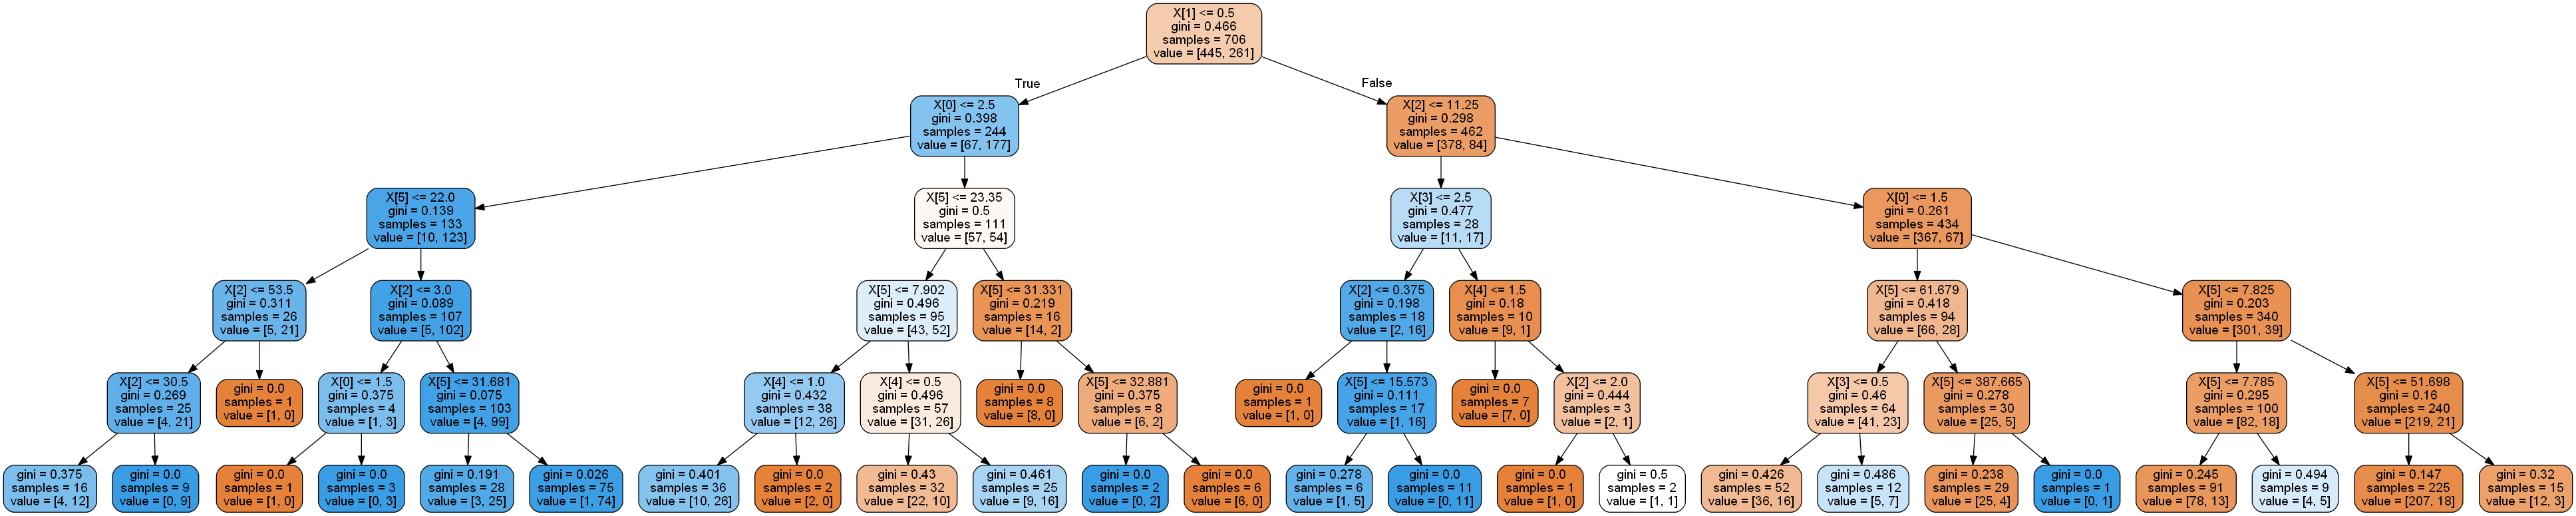

In [46]:
import pydotplus

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
dot_data = StringIO()
export_graphviz(sk_tree,out_file=dot_data,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [47]:
train_data

,pclass,survived,sex,age,sibsp,parch,fare
0,3.0,0.0,0,29.838978,0.0,0.0,7.750
1,2.0,0.0,1,39.000000,0.0,0.0,26.000
2,2.0,1.0,0,40.000000,0.0,0.0,13.000
3,3.0,1.0,0,31.000000,1.0,1.0,20.525
4,3.0,1.0,0,29.838978,2.0,0.0,23.250
...,...,...,...,...,...,...,...
701,1.0,0.0,1,49.000000,0.0,0.0,26.000
702,2.0,1.0,0,30.000000,0.0,0.0,13.000
703,2.0,1.0,0,22.000000,0.0,0.0,10.500
704,1.0,1.0,0,19.000000,0.0,0.0,30.000


In [49]:
#Random Forests Classifier: random forests is a collection of decision trees and chooses the result fo majority of trees in the forest
list_acc=[]
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
for i in range(1,50):
    rf=RandomForestClassifier(n_estimators=i,max_depth=5,criterion='entropy')
    acc=cross_val_score(rf,train_data[input_cols],train_data["survived"],cv=5).mean()
    list_acc.append(acc)


In [50]:
print(list_acc)

[0.7606532813904705, 0.7564279292777945, 0.7974428129058038, 0.7847667565677755, 0.7946359005094397, 0.796074318249925, 0.8116371990810108, 0.7988812306462891, 0.8102487264009589, 0.8173309359704326, 0.791848966137249, 0.8074018579562481, 0.8074218359804215, 0.810278693437219, 0.8059734292278493, 0.8116471880930975, 0.807371890919988, 0.8144840675257218, 0.8173009689341726, 0.8130856058335831, 0.821576266107282, 0.8187194086504844, 0.80882029767256, 0.8116471880930975, 0.8045549895115374, 0.8003296373988613, 0.8102387373888721, 0.8130756168214962, 0.813085605833583, 0.8102387373888721, 0.813085605833583, 0.811667166117271, 0.8102587154130456, 0.8144640895015482, 0.8130556387973229, 0.8201278593547098, 0.8102387373888723, 0.8158825292178603, 0.8130756168214962, 0.8173109579462592, 0.821576266107282, 0.8130955948456698, 0.8187493756867446, 0.8201578263909699, 0.8088103086604734, 0.8116371990810108, 0.814474078513635, 0.8144840675257218, 0.8088103086604734]


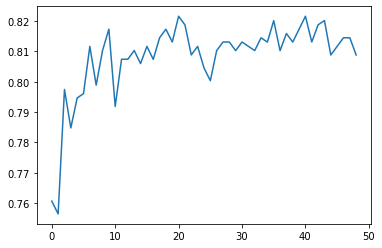

In [51]:
import matplotlib.pyplot as plt
plt.plot(list_acc)

In [67]:
np.argmin(list_acc)

1

In [77]:
test_acc=RandomForestClassifier(n_estimators=20,max_depth=5,criterion='entropy')
rf.fit(train_data[input_cols],train_data["survived"])

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=49)

In [78]:
rf.score(train_data[input_cols],train_data["survived"])

0.8498583569405099

In [79]:
rf.score(test_data[input_cols],test_data["survived"])

0.7854785478547854

In [100]:
actest=pd.read_csv("Test.csv")
actest.drop(columns=["name","boat","body","cabin","embarked","ticket","home.dest"],inplace=True)
actest = actest.fillna(actest["age"].mean())
actest['sex']= label_encoder.fit_transform(actest['sex'])
actest.head()

,pclass,sex,age,sibsp,parch,fare
0,1.0,1,36.000000,0.0,0.0,26.3875
1,3.0,0,30.027422,8.0,2.0,69.5500
2,1.0,1,30.027422,0.0,0.0,50.0000
3,2.0,1,34.000000,0.0,0.0,13.0000
4,2.0,1,28.000000,0.0,0.0,13.0000


In [113]:
outl=[]
for i in range(len(actest)):
    outl.append(dt.predict(actest.loc[i]))
print(outl)

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]


In [114]:
out=pd.DataFrame(outl,columns=["survived"])
out.to_csv("out.csv")